> Это пример решения данной задачи с использованием Keras. Вы можете использовать этот кернал для дальнейших своих исследований и эксперементов.
# Car classification
![](http://img1.joyreactor.cc/pics/post/автопром-ваз-лимузин-ватермарк-351083.jpeg)

### Основная идея - берем предобученую на imagenet сеть Xception и дообучаем под нашу задачу.
По ходу кернела я буду давать комментарии и подсказки (где что можно подкрутить и что можно еще попробовать, чтоб улучшить скор).  
Многие параметры специально установлены не оптимальным образом ;)

Удачи и Поехали!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pickle
import scipy.io
import tarfile
import csv
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

In [3]:
import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [5]:
print(os.listdir("/data1/datasets/kaggle_car_classification"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
#print('Keras        :', keras.__version__)

['test', 'train', 'sample-submission.csv', 'kaggle_car_classif.zip', 'train.csv']
Python       : 3.9.12 (main, Jun  1 2022, 11:38:51) 
Numpy        : 1.22.3
Tensorflow   : 2.9.1


In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [14]:
!nvidia-smi

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Jul 31 13:35:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   59C    P8    35W / 350W |    872MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------

In [15]:
!pip freeze > requirements.txt

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Setup

In [31]:
EPOCHS               = 10
BATCH_SIZE           = 64
LR                   = 1e-4
VAL_SPLIT            = 0.15 #15%

CLASS_NUM            = 10
IMG_SIZE             = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/data1/datasets/kaggle_car_classification/'
WORK_PATH = "./work/"

In [32]:
os.makedirs(WORK_PATH,exist_ok=False)

In [17]:
# Setting seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [18]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

Id  Category
0  100155.jpg         0
1  100306.jpg         0
2  100379.jpg         0
3  100380.jpg         0
4  100389.jpg         0

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [20]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [ ]:
# print('Распаковываем картинки')
# # Will unzip the files so that you can see them..
# for data_zip in ['train.zip', 'test.zip']:
#     with zipfile.ZipFile("../input/"+data_zip,"r") as z:
#         z.extractall(PATH)
        
# print(os.listdir(PATH))

Пример картинок (random sample)


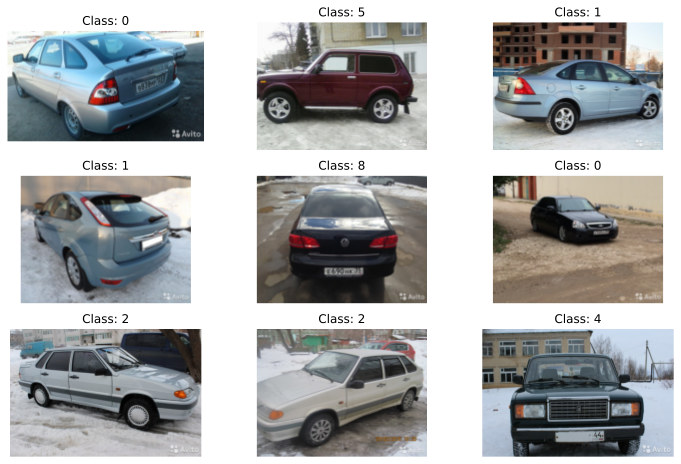

In [21]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

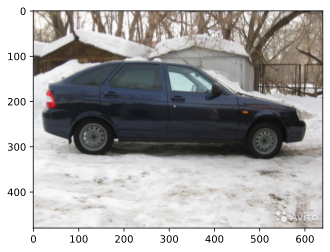

(640, 480)

In [22]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Data

### Data augmentation

In [23]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)
# Официальная дока https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 50, #5
    shear_range=0.2, # was not
    zoom_range=[0.75,1.25], # was not   
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True) # False

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Попробовать подключить сторонние более продвинутые библиотеки аугминтации изображений

### datagen

In [24]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# кстати, для сабмишена мы используем другой источник для генератора flow_from_dataframe? 
# почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# Model

### подгружаем предобученую сеть Xception

In [25]:
# Попробовать еще другие архитектуры сетей...
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83683744/83683744 [==============================] - 7s 0us/step


In [26]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [27]:
# Устанавливаем новую "голову"
# Тут можно попробовать добавить Batch Normalization.

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x) # Этого не было 
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

## Fit

In [33]:
checkpoint = ModelCheckpoint(WORK_PATH+'best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

# Можно попробовать добавить разные техники управления Learning Rate
# Например:
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
# http://teleported.in/posts/cyclic-learning-rate/

In [34]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

# попробовать применить transfer learning с fine-tuning
# Сначала замораживаем все слои кроме новой "головы"
# Потом, когда мы научили последние слои (голову) под новую задачу, можно разморозить все слои и пройтись маленьким лернинг рейтом

/tmp/ipykernel_14698/1023923584.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10


2022-07-31 13:53:23.094855: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-31 13:53:23.095334: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-07-31 13:53:23.524148: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-31 13:53:23.524171: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more

207/207 [==============================] - ETA: 0s - loss: 1.5110 - accuracy: 0.4776
Epoch 1: saving model to ./work/best_model.hdf5
207/207 [==============================] - 120s 554ms/step - loss: 1.5110 - accuracy: 0.4776 - val_loss: 1.4874 - val_accuracy: 0.6535
Epoch 2/10
207/207 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.7656
Epoch 2: saving model to ./work/best_model.hdf5
207/207 [==============================] - 113s 546ms/step - loss: 0.6356 - accuracy: 0.7656 - val_loss: 0.7499 - val_accuracy: 0.8111
Epoch 3/10
207/207 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8503
Epoch 3: saving model to ./work/best_model.hdf5
207/207 [==============================] - 113s 546ms/step - loss: 0.4091 - accuracy: 0.8503 - val_loss: 0.4161 - val_accuracy: 0.8514
Epoch 4/10
207/207 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8891
Epoch 4: saving model to ./work/best_model.hdf5
207/207 [=====================

In [35]:
model.save(WORK_PATH+'model_last.hdf5')
model.load_weights(WORK_PATH+'best_model.hdf5')

In [36]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 18s 480ms/step - loss: 0.2896 - accuracy: 0.9064
Accuracy: 90.64%


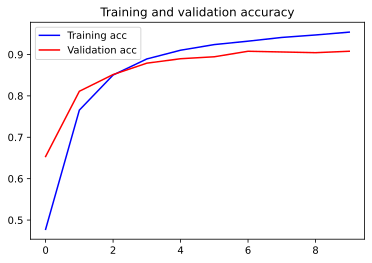

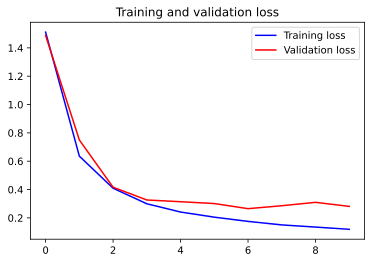

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Submission

In [38]:
test_sub_generator.samples

6675

In [39]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

105/105 [==============================] - 21s 200ms/step


In [43]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
print('Save submition')
submission.to_csv(WORK_PATH+'submission.csv', index=False)
# Попробовать добавить TTA
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


In [42]:
submission.head()

Id Category
0  305108.jpg        7
1  295075.jpg        0
2   31197.jpg        4
3   93598.jpg        7
4   87877.jpg        9

In [44]:
# Clean PATH
import shutil
shutil.rmtree(WORK_PATH)

# Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Добавить аугментацию
* Поиграться с архитектурой
* Подобрать другие переменные (размер картинки, батч и тп)
* Добавить политику обучения
* Добавить TTA
* Найти и обучиться на других внешних данных
* Построить ансамбль из разных архитектур